## Most of the code below will be borrowed from langchain documentation and tutorials. I will highlight the important parts and eventually how to dissect these graphs

## Here is the flow of this notebook

- State based graph models and how to define them in langgraph
- Simple graph, and chaining nodes
- How to route queries from user - Do I call a tool or just answer the question?
- agentic workflows - liek ReAct
- Agents with memory

In [29]:
pip install -U langchain-ollama langchain-core langchain


  Attempting uninstall: langgraph-prebuilt
    Found existing installation: langgraph-prebuilt 1.0.6
    Uninstalling langgraph-prebuilt-1.0.6:
      Successfully uninstalled langgraph-prebuilt-1.0.6
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.6
    Uninstalling langgraph-1.0.6:
      Successfully uninstalled langgraph-1.0.6
  Attempting uninstall: langchain
    Found existing installation: langchain 1.2.6
    Uninstalling langchain-1.2.6:
      Successfully uninstalled langchain-1.2.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [langchain]
Note: you may need to restart the kernel to use updated packages.


In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" excited!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

def node_4(state):
    print("---Node 4---")
    return {"graph_state": state['graph_state'] +" wohoo!"}

## Edges

[Edges](https://docs.langchain.com/oss/python/langgraph/graph-api/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://docs.langchain.com/oss/python/langgraph/graph-api/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based on some logic.

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

Now, we build the graph from our components defined above.

The [StateGraph class](https://docs.langchain.com/oss/python/langgraph/graph-api/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the  [`START` Node, a special node](https://docs.langchain.com/oss/python/langgraph/graph-api/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://docs.langchain.com/oss/python/langgraph/graph-api/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://docs.langchain.com/oss/python/langgraph/graph-api/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

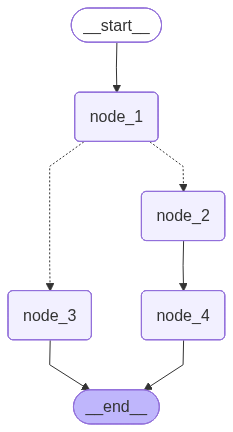

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)


# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Langghcain does not have the above graph. But if you need to know how to connect and add edges beyond the tutorial, the above graph mmight be helpful

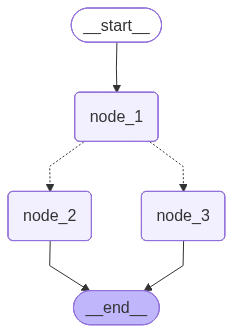

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"graph_state" : "Hi, "})

---Node 1---
---Node 2---


{'graph_state': 'Hi,  I am excited!'}

# As we can see above we can build complex graphs. For now just assume them as states. Next we will add chat and tool logic

Now, let's build up to a simple chain that combines 4 concepts.

* Using [chat messages](https://docs.langchain.com/oss/python/langchain/messages) as our graph state
* Using [chat models](https://docs.langchain.com/oss/python/integrations/chat) in graph nodes
* [Binding tools](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to our chat model
* [Executing tool calls](https://docs.langchain.com/oss/python/langchain/models#tool-execution-loop) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)


LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [23]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


# Here is where I diverge from the tutorials, I will be working with the Qwen model to see how tool calling works in stateful actions

In [24]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="qwen2.5:7b-instruct", temperature=0.3)


result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [25]:
result

AIMessage(content='Certainly! Orca whales, also known as killer whales, can be observed in various parts of the United States. Here are some of the best places to see them:\n\n1. **Washington State (Puget Sound)**\n   - **Best Time:** Late summer and fall.\n   - **Highlights:**\n     - **J Pod, K Pod, L Pod**: These pods are frequently seen in the waters around Washington State. J Pod is particularly famous for its close encounters with tourists.\n     - **Orcas in the Wild Tours**: Various tour operators offer boat tours that can take you to see these orcas up close.\n\n2. **British Columbia (Canada)**\n   - While not technically within the United States, British Columbia shares a coastline with Washington and is home to several pods of orcas.\n   - **Best Time:** Late summer through early fall.\n   - **Highlights:**\n     - **Tahsis Whale Watching**: Located in Tofino, this area offers excellent opportunities to see orcas.\n\n3. **Alaska**\n   - **Best Time:** June to September.\n   

AIMessage(content="Certainly! Orca whales, also known as killer whales, are fascinating creatures and can be observed in various parts of the United States. Here are some of the best places to see orcas:\n\n1. **Washington State (Puget Sound)**\n   - **Best Time:** Late summer through early fall.\n   - **Operators:** Whale Watch Puget Sound, OrcaWatch, and others offer daily tours from Seattle, Bainbridge Island, and other nearby locations.\n   - **Highlights:** The resident pods of orcas are frequently seen in this area. Pods like J, K, and L are commonly observed.\n\n2. **British Columbia (Canada)**\n   - While not strictly within the United States, many tour operators based in Washington State also offer trips that extend into Canadian waters.\n   - **Best Time:** Late summer through early fall.\n   - **Operators:** West Coast Whale Watch, Orca Express, and others provide opportunities to see orcas.\n\n3. **Alaska**\n   - **Best Time:** June through September.\n   - **Operators:** Alaska Whale Foundation, Kenai Fjords Tours, and others offer whale watching tours from various coastal towns like Seward and Homer.\n   - **Highlights:** The waters around Southeast Alaska are home to transient orcas that feed on marine mammals.\n\n4. **California (Monterey Bay)**\n   - **Best Time:** Late summer through early fall.\n   - **Operators:** Monterey Bay Whale Watch offers tours from various locations along the California coast, including Monterey and Santa Cruz.\n   - **Highlights:** While not as common as in other areas, orcas can occasionally be seen here.\n\n5. **Maine (Penobscot Bay)**\n   - **Best Time:** Late summer through early fall.\n   - **Operators:** Maine Whale Watch offers tours from Rockland and other coastal towns.\n   - **Highlights:** The waters around Penobscot Bay are home to both resident and transient orcas.\n\n### Tips for Your Trip:\n- **Choose a Reputable Tour Operator:** Look for operators that have a good track record, use eco-friendly practices, and prioritize the well-being of the whales.\n- **Check Weather Conditions:** Orca sightings can be weather-dependent. Check forecasts before your trip.\n- **Be Patient:** Whale watching is often about patience. Even if you don't see orcas on one day, there's always a chance they'll appear another time.\n\nEnjoy your whale-watching adventure!", additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b-instruct', 'created_at': '2026-01-25T00:52:08.379552Z', 'message': {'role': 'assistant', 'content': ''}, 'done': True, 'done_reason': 'stop', 'total_duration': 17486523333, 'load_duration': 3951145458, 'prompt_eval_count': 85, 'prompt_eval_duration': 359807833, 'eval_count': 503, 'eval_duration': 9823241028}, id='lc_run--019bf2a2-bfe6-7983-a6cc-ef6e0c49dfab-0', tool_calls=[], invalid_tool_calls=[])


# Below is what OpenAIs gpt-4o outputted 

AIMessage(content='One of the best places to see orcas in the United States is the Pacific Northwest, particularly around the San Juan Islands in Washington State. Here are some details:\n\n1. **San Juan Islands, Washington**: These islands are a renowned spot for whale watching, with orcas frequently spotted between late spring and early fall. The waters around the San Juan Islands are home to both resident and transient orca pods, making it an excellent location for sightings.\n\n2. **Puget Sound, Washington**: This area, including places like Seattle and the surrounding waters, offers additional opportunities to see orcas, particularly the Southern Resident killer whale population.\n\n3. **Olympic National Park, Washington**: The coastal areas of the park provide a stunning backdrop for spotting orcas, especially during their migration periods.\n\nWhen planning a trip for whale watching, consider peak seasons for orca activity and book tours with reputable operators who adhere to responsible wildlife viewing practices. Additionally, land-based spots like Lime Kiln Point State Park, also known as “Whale Watch Park,” on San Juan Island, offer great opportunities for orca watching from shore.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 228, 'prompt_tokens': 67, 'total_tokens': 295, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-57ed2891-c426-4452-b44b-15d0a5c3f225-0', usage_metadata={'input_tokens': 67, 'output_tokens': 228, 'total_tokens': 295, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Clearly we see some differences, but we will keep going

In [26]:
result.response_metadata

{'model': 'qwen2.5:7b-instruct',
 'created_at': '2026-01-25T01:24:33.320254Z',
 'done': True,
 'done_reason': 'stop',
 'total_duration': 13781343500,
 'load_duration': 93117375,
 'prompt_eval_count': 85,
 'prompt_eval_duration': 270085167,
 'eval_count': 516,
 'eval_duration': 9993729425,
 'logprobs': None,
 'model_name': 'qwen2.5:7b-instruct',
 'model_provider': 'ollama'}

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://docs.langchain.com/oss/python/integrations/chat) and [tool calling interface](https://blog.langchain.com/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

## People say that access to tools makes LLMs intelligent.

##  This is what industry and non-critical academics will say. Do not get me wrong. Its extremely useful to automate worklfows and make decisions quite some obvious decisions

## If I really see intelligence, I will come back and change this statement. Quite open to being wrong

In [42]:
from langchain.tools import tool


@tool
def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first float
        b: second float
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

### Now we will pass messages as state

In [43]:
from langgraph.graph import MessagesState
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [44]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='4c060d3e-8ecd-424d-9495-94d64c839ce8', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='952acdfb-bcd9-48a4-872b-fe3e196034bd'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='91f078ee-0b57-47df-9491-81e6d071f5d2', tool_calls=[], invalid_tool_calls=[])]

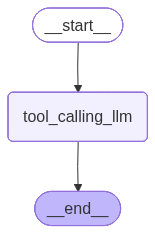

In [45]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [47]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply two and and twent two")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply two and and twent two
================================== Ai Message ==================================
Tool Calls:
  multiply (67e601da-7b63-4e7b-b70a-299c0446dcbd)
 Call ID: 67e601da-7b63-4e7b-b70a-299c0446dcbd
  Args:
    a: 2
    b: 22


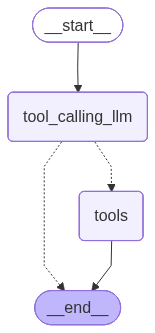

In [48]:

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
messages = graph.invoke({"messages": HumanMessage(content="hello if my friend has 2 m by 5 m fence. What is the area?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hello if my friend has 2 m by 5 m fence. What is the area?
================================== Ai Message ==================================

The area of a rectangle can be calculated using the formula:

\[ \text{Area} = \text{length} \times \text{width} \]

Given that your friend's fence dimensions are 2 meters by 5 meters, we can calculate the area as follows:

\[ \text{Area} = 2 \, \text{m} \times 5 \, \text{m} \]

Let me compute this for you.
Tool Calls:
  multiply (a97ecf76-e602-4f80-aecd-d34b06ed8e82)
 Call ID: a97ecf76-e602-4f80-aecd-d34b06ed8e82
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10.0


# Great, now you might ask - Why do I need AI for multilpication ? I could just create a script that does this. 

## Thats correct. But we need this building block to start creating `agentic` workflows. We will now create something similar to the calculator tool I played around with earlier.

### This time I will make it state based

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.com/planning-for-agents/) can be applied to many types of tools. 

In [71]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOllama(model="qwen2.5:7b-instruct", temperature=0.3)
llm_with_tools = llm_with_tools = llm.bind_tools(tools) # I dont think we can do parallel tool calls

Let's create our LLM and prompt it with the overall desired agent behavior.

In [72]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Now we specify a system message. Think of it as a pre conditioning prompt

In [73]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# As you can see, we add the system message to the messages coming in. Context

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

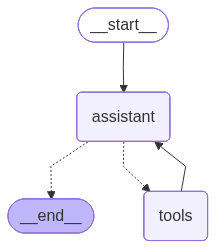

In [74]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [80]:
messages = [HumanMessage(content="david and goliath had 2 and 3 apples respectively. Jesus multipleied by the total by 10. How many apples do tey have now")]
messages = react_graph.invoke({"messages": messages})

In [81]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

davi and goliath had 2 and 3 apples respectively. Jesus multipleied by the total by 10. How many apples do tey have now
================================== Ai Message ==================================

First, let's calculate the total number of apples Davi and Goliath have together. Then we will multiply that total by 10 as mentioned.
Tool Calls:
  add (ea076fb7-e205-4e80-b04c-dbaa6d0899d5)
 Call ID: ea076fb7-e205-4e80-b04c-dbaa6d0899d5
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

The total number of apples Davi and Goliath have together is 5. Jesus then multiplied this total by 10, resulting in 50 apples. Therefore, after this operation, they have 50 apples collectively.


## Great, its doing something... We will have to now scale.

In [82]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Sure, I need the numbers to multiply first. Could you please provide them?


## As you can see it doesnt seem to have information from the previous conversation. Ideally we wanted the output to be 100. 

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://docs.langchain.com/oss/python/langgraph/persistence) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [84]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [86]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (f0e173ef-4cf1-4416-a7df-a2f7865fb672)
 Call ID: f0e173ef-4cf1-4416-a7df-a2f7865fb672
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [87]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (f0e173ef-4cf1-4416-a7df-a2f7865fb672)
 Call ID: f0e173ef-4cf1-4416-a7df-a2f7865fb672
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (eb693910-1e9f-4ccc-ae9c-a2338a4521b6)
 Call ID: eb693910-1e9f-4ccc-ae9c-a2338a4521b6
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ===================

In [88]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (f0e173ef-4cf1-4416-a7df-a2f7865fb672)
 Call ID: f0e173ef-4cf1-4416-a7df-a2f7865fb672
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (eb693910-1e9f-4ccc-ae9c-a2338a4521b6)
 Call ID: eb693910-1e9f-4ccc-ae9c-a2338a4521b6
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ===================

## as you can see, the thread keeps going. This seems like the simplest form of memory.

In [93]:

messages = [HumanMessage(content="Is the answer larger than 28?")]
messages = react_graph_memory.invoke({"messages": messages}, config)

In [94]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (f0e173ef-4cf1-4416-a7df-a2f7865fb672)
 Call ID: f0e173ef-4cf1-4416-a7df-a2f7865fb672
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (eb693910-1e9f-4ccc-ae9c-a2338a4521b6)
 Call ID: eb693910-1e9f-4ccc-ae9c-a2338a4521b6
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ===================

In [96]:
# now lets see if we remove the config, we get an error
messages = [HumanMessage(content="Is the answer larger than 28?")]
messages = react_graph_memory.invoke({"messages": messages})

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id